In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [42]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words.pickle'

In [10]:
syllable_df = pd.read_pickle(df_loc)

In [19]:
syllable_df[:3]

,start_time,end_time,labels,utterance_number,PoS,position_in_utterance,indv,indvi,age,sex,key,audio,rate,spectrogram
0,4.885333,5.255262,well,0,RB,0,s07,0,o,f,s0702b,"[-0.009891687687084304, -0.008258749127846935,...",16000,"[[0.0, 0.0, 0.0, 0.004942009, 0.102402754, 0.0..."
1,5.698899,5.903525,yknow,0,PRP_VBP,2,s07,0,o,f,s0702b,"[0.0020050267415568897, -0.00886577761757358, ...",16000,"[[0.0, 0.0, 0.0, 0.0, 0.23456699, 0.37280002, ..."
2,5.903525,6.099023,it,0,PRP,3,s07,0,o,f,s0702b,"[-0.4616742369795508, -0.22130549839909638, -0...",16000,"[[0.0, 0.0, 0.0, 0.0, 0.34458634, 0.36319825, ..."


In [18]:
len(syllable_df)

9062

In [12]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s07,s02,s06,s03,s27,s22,s26,s23,s09,s20
0,1643,362,667,404,1127,1099,837,1230,1308,385


In [21]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:15]
    .T
)
freq_words

,i,and,the,a,to,that,uh,of,it,in,was,yknow,so,just,they
0,459,402,236,219,208,170,170,162,155,145,145,114,100,92,86


### subset dataframe
- there is some noise in labelling we want to remove

Text(0.5, 1.0, 'min')

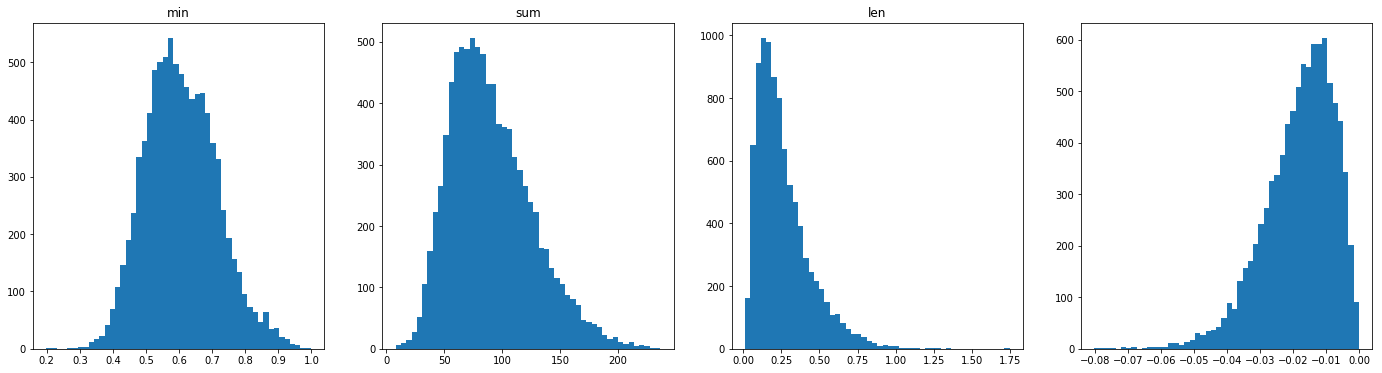

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')

In [22]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:15]
    .T
)
freq_words

,i,and,the,a,to,that,uh,of,it,in,was,yknow,so,just,they
0,459,402,236,219,208,170,170,162,155,145,145,114,100,92,86


i


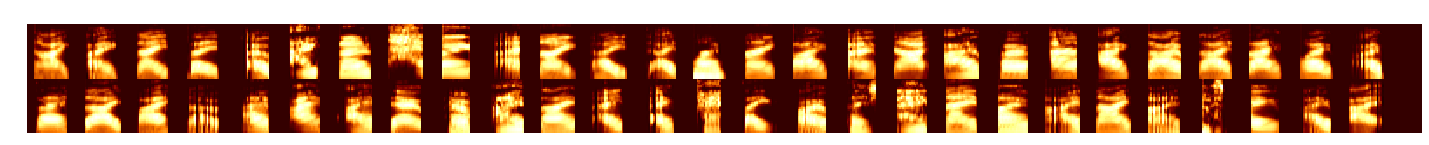

and


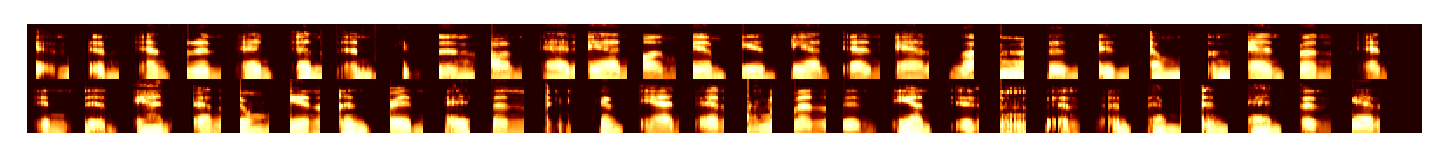

the


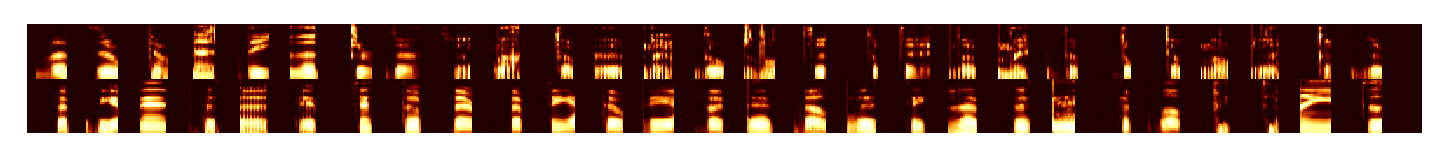

a


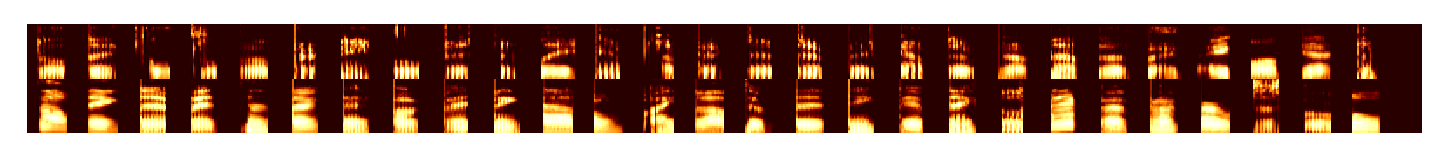

to


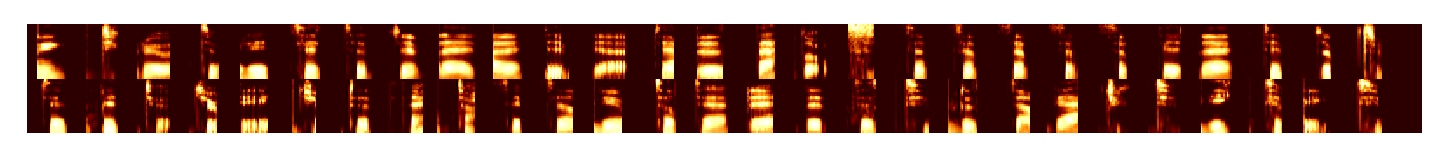

that


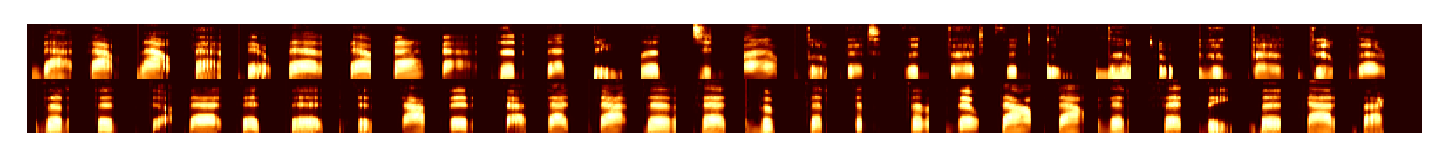

uh


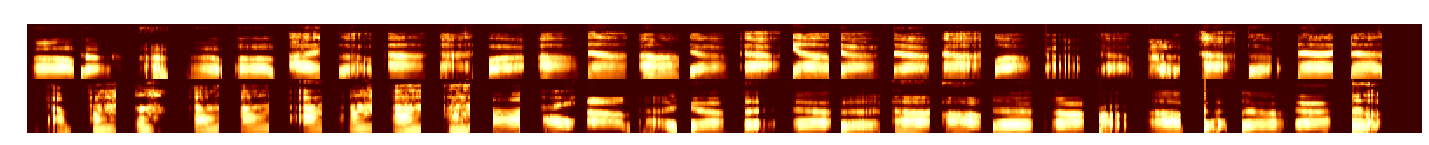

of


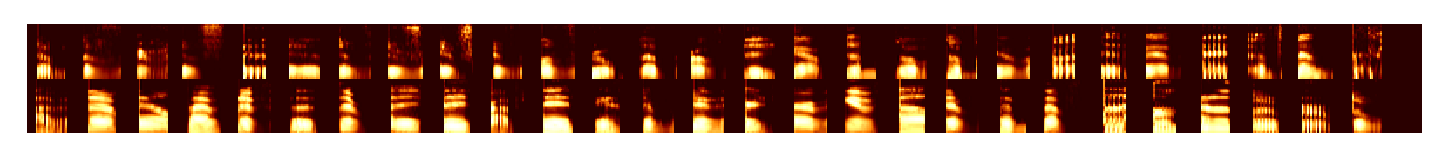

it


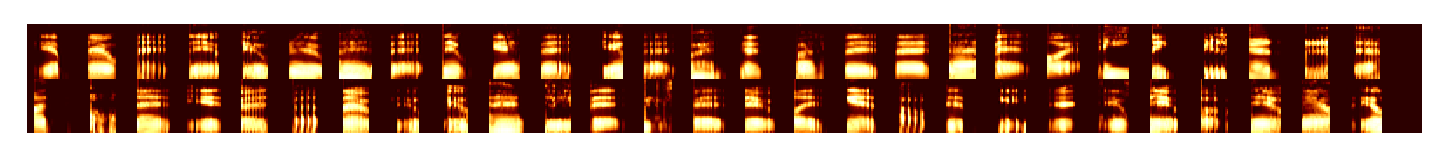

in


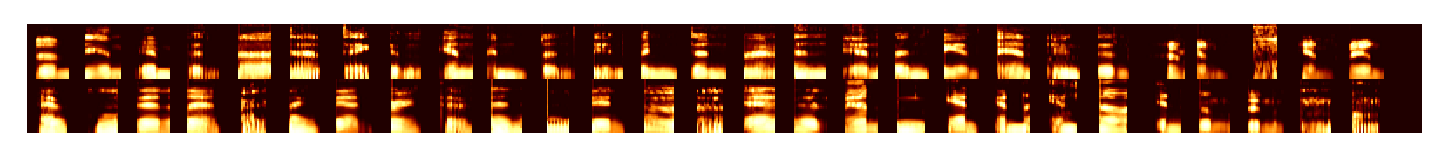

was


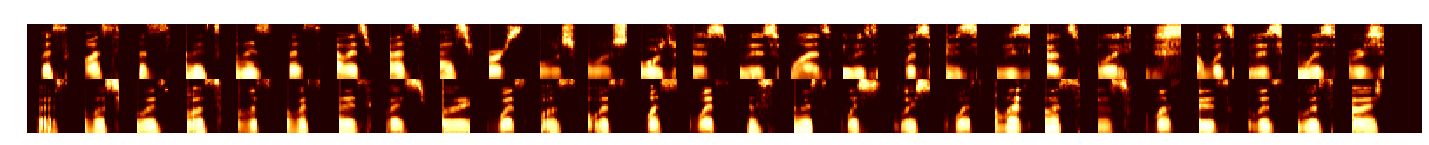

yknow


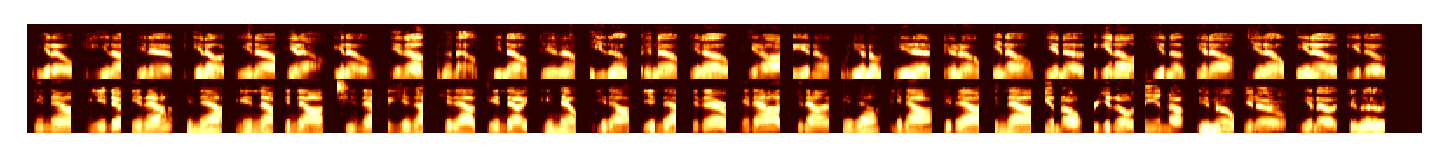

so


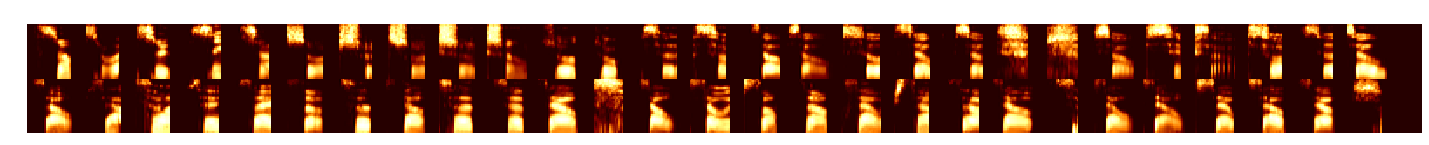

just


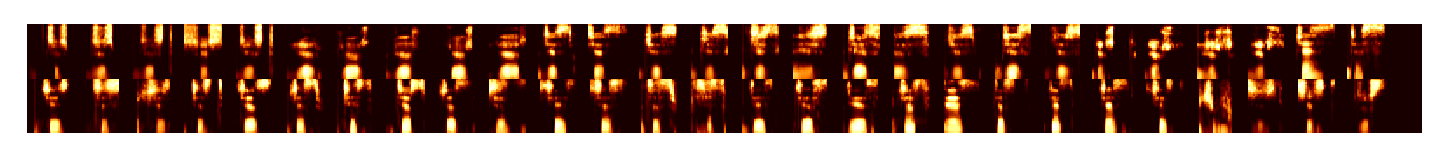

they


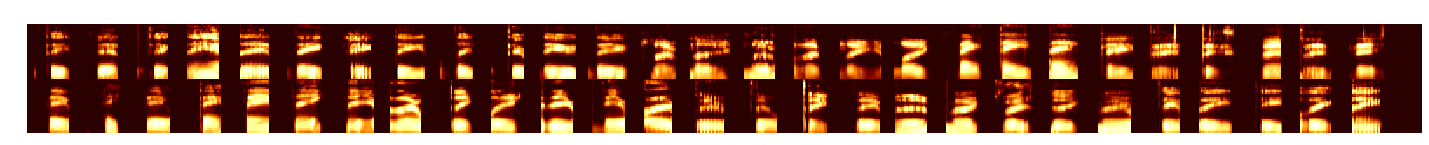

In [60]:
for word in tqdm(freq_words):
    subset_df = syllable_df[
        syllable_df.labels == word
    ]
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in specs]
    print(word)
    draw_spec_set(specs, zoom=1, maxrows=2, colsize=25)

In [28]:
subset_df = syllable_df[
    syllable_df.labels.isin(freq_words.columns)
]

In [45]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2863, 928)

(25.0, 10) (320, 800) 25.0 32 800


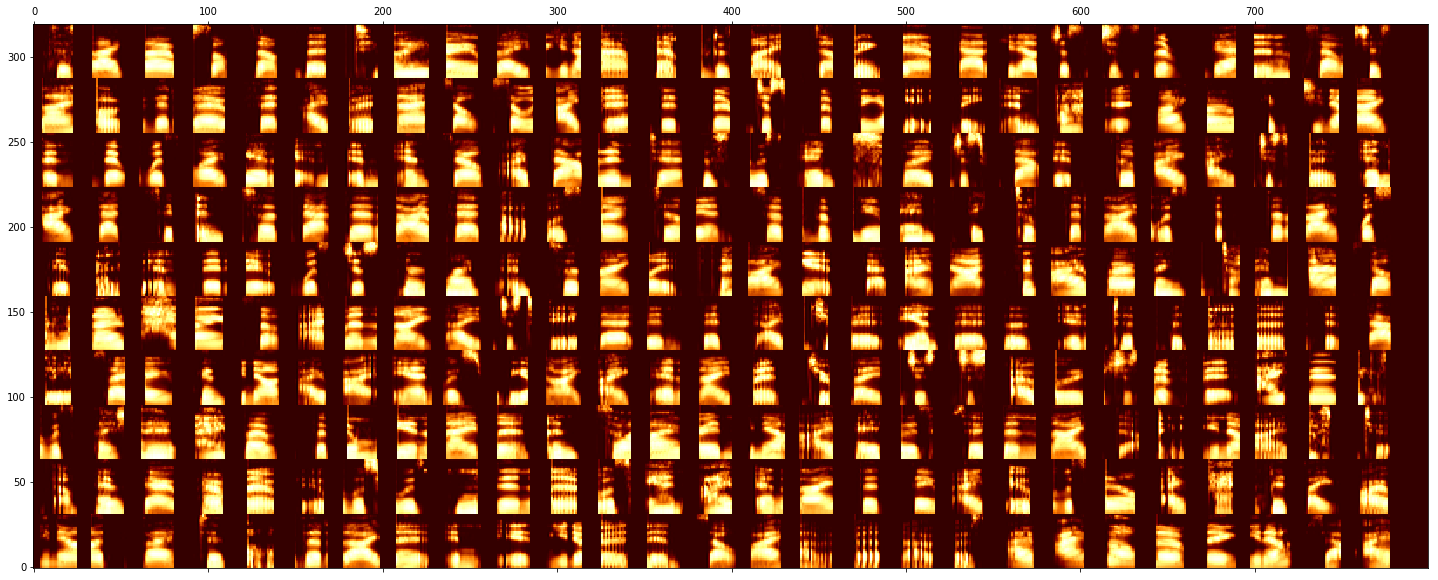

In [47]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [49]:
subset_df[:3]

,start_time,end_time,labels,utterance_number,PoS,position_in_utterance,indv,indvi,age,sex,key,audio,rate,spectrogram
1,5.698899,5.903525,yknow,0,PRP_VBP,2,s07,0,o,f,s0702b,"[0.0020050267415568897, -0.00886577761757358, ...",16000,"[[0.0, 0.0, 0.0, 0.0, 0.23456699, 0.37280002, ..."
2,5.903525,6.099023,it,0,PRP,3,s07,0,o,f,s0702b,"[-0.4616742369795508, -0.22130549839909638, -0...",16000,"[[0.0, 0.0, 0.0, 0.0, 0.34458634, 0.36319825, ..."
4,6.526125,6.640816,i,0,PRP,6,s07,0,o,f,s0702b,"[0.045568528736657135, 0.048400479339309146, 0...",16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.20396546, 0.23709..."


#### cluster and plot

In [50]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [51]:
fit = umap.UMAP()

In [52]:
np.shape(specs_flattened)

(2863, 928)

In [53]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [54]:
z = np.vstack(z)

### variation across populations

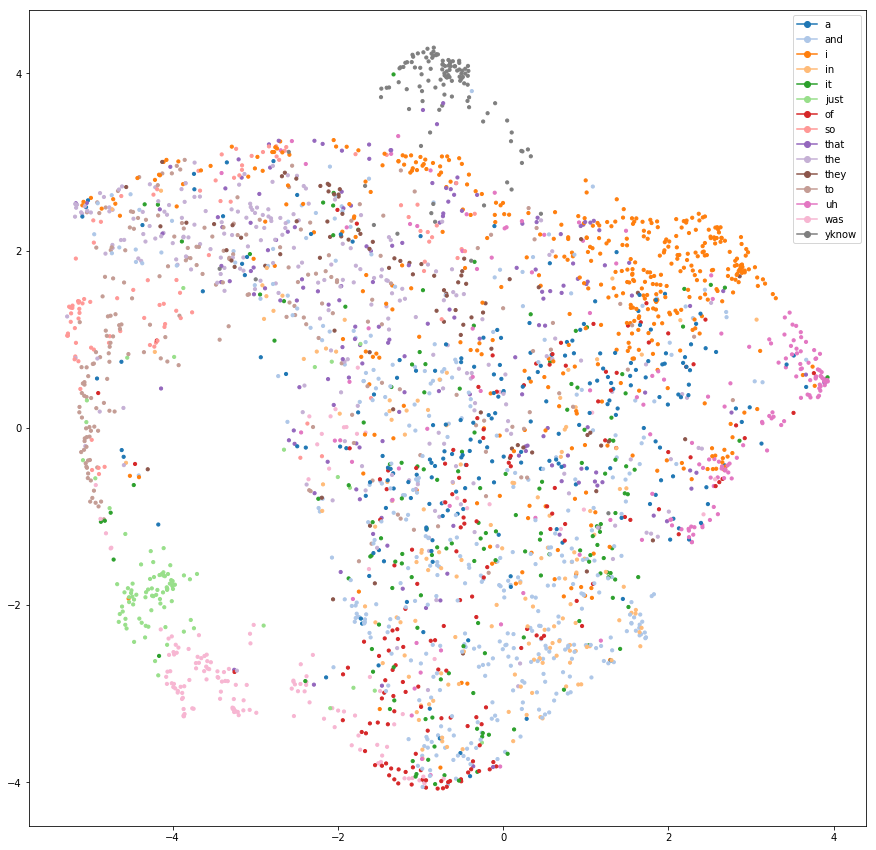

In [56]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = subset_df.labels.values, s=10, ax = ax)
#ax.set_xlim([-15,15])

### draw transitions by population